In [20]:
%matplotlib inline

import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

# Load and prepare data

In [21]:
f = h5py.File('matrix_data/DRIP_Seq.hdf5', 'r')

In [22]:
g = f['mNET_Seq_around_gene_centers'].keys()

In [23]:
g

KeysViewWithLock(<HDF5 group "/mNET_Seq_around_gene_centers" (3 members)>)

In [24]:
d = f['DRIP_around_origins/HO_CD_rep_2']

In [25]:
read_counts = {
    'rep_1': 27.148602,
    'rep_2': 23.52997,
    'rep_1_input': 29.02927,
    'rep_2_input': 30.379016,
    'groseq': 11.806518
}

In [30]:
drip_data = {}
drip_data['ho_cd'] = (np.concatenate([np.array(f['DRIP_around_origins']['CD_HO_rep_1'])[:, ::-1]/read_counts['rep_1'],
                                      np.array(f['DRIP_around_origins']['HO_CD_rep_1'])/read_counts['rep_1']]) +              
                      np.concatenate([np.array(f['DRIP_around_origins']['CD_HO_rep_2'])[:, ::-1]/read_counts['rep_2'],
                                    np.array(f['DRIP_around_origins']['HO_CD_rep_2'])/read_counts['rep_2']])
                     )/2
drip_data['ho_cd_input'] = (np.concatenate([np.array(f['DRIP_around_origins']['CD_HO_rep_1_input'])[:, ::-1]/read_counts['rep_1_input'],
                                            np.array(f['DRIP_around_origins']['HO_CD_rep_1_input'])/read_counts['rep_1_input']]) +
                      np.concatenate([np.array(f['DRIP_around_origins']['CD_HO_rep_2_input'])[:, ::-1]/read_counts['rep_2_input'],
                                      np.array(f['DRIP_around_origins']['HO_CD_rep_2_input'])/read_counts['rep_2_input']])
                     )/2
drip_data['centers'] = (np.concatenate([np.array(f['DRIP_around_gene_centers']['rep_1']),
                                        np.array(f['DRIP_around_gene_centers']['rep_1_antisense'])[:, ::-1]])/read_counts['rep_1'] +
                        np.concatenate([np.array(f['DRIP_around_gene_centers']['rep_2']),
                                        np.array(f['DRIP_around_gene_centers']['rep_2_antisense'])[:, ::-1]])/read_counts['rep_2'])/2
drip_data['centers_input'] = (np.concatenate([np.array(f['DRIP_around_gene_centers']['rep_1_input']),
                                        np.array(f['DRIP_around_gene_centers']['rep_1_input_antisense'])[:, ::-1]])/read_counts['rep_1_input'] +
                        np.concatenate([np.array(f['DRIP_around_gene_centers']['rep_2_input']),
                                        np.array(f['DRIP_around_gene_centers']['rep_2_input_antisense'])[:, ::-1]])/read_counts['rep_2_input'])/2

In [31]:
rfd = {}
rfd['ho_cd'] = np.concatenate([-np.array(f['RFD_around_origins']['CD_HO'])[:, ::-1],
                               np.array(f['RFD_around_origins']['HO_CD'])
                              ])
rfd['centers'] = np.array(f['RFD_around_gene_centers']['centers'])

In [32]:
gro_seq = {}
plus = np.concatenate([
        -np.array(f['GRO_Seq_around_origins']['CD_HO_plus'])[:, ::-1],
        np.array(f['GRO_Seq_around_origins']['HO_CD_plus'])
    ])/read_counts['groseq']
minus = np.concatenate([
        -np.array(f['GRO_Seq_around_origins']['CD_HO_minus'])[:, ::-1],
        np.array(f['GRO_Seq_around_origins']['HO_CD_minus'])
    ])/read_counts['groseq']

gro_seq['ho_cd'] = (plus - minus)
# Script for generating these files already inverted coordinates
gro_seq['centers'] = (np.array(f['GRO_Seq_around_gene_centers']['sense']) - 
                      np.array(f['GRO_Seq_around_gene_centers']['antisense']))/read_counts['groseq']

In [33]:
f.close()

In [34]:
single_genes_body = np.load('matrix_data/index_of_single_genes.npy')

In [35]:
def bootstrap_one_sample(variable_1, n_repeats, verbose=True):
    resampled_var1 = np.zeros((n_repeats, variable_1.shape[1]), dtype=np.float32)
    for i in range(n_repeats):
        if verbose and not i % (n_repeats//10): 
            print(i)
        random_sample = np.random.choice(len(variable_1) - 1, len(variable_1) - 1, replace=True)
        resampled_var1[i, :] = variable_1[random_sample, :].mean(axis=0)
    return resampled_var1

def plot_mean_with_95ci(bootstrap_sample, color, ax, x=None):
    nrow, ncol = bootstrap_sample.shape    
    if x is None:
        x = np.linspace(-12, 12, ncol)
    ax.plot(x, bootstrap_sample.mean(axis=0), color=color)
    lower_bound = np.percentile(bootstrap_sample, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_sample, 97.5, axis=0)
    ax.fill_between(x, lower_bound, upper_bound, color=color, alpha = 0.5)

In [36]:
drip_boot = {i: bootstrap_one_sample(drip_data[i][single_genes_body, :], 10000) 
             for i in ['ho_cd', 'ho_cd_input']}
#drip_boot_sig = {i: bootstrap_one_sample(samples[i][single_genes_body_significant, :], 10000) for i in ['ho_cd', 'ho_cd_input']}
#drip_boot_non_sig = {i: bootstrap_one_sample(samples[i][not_sig, :], 10000) for i in ['ho_cd', 'ho_cd_input']}

drip_boot['gene_centers'] = bootstrap_one_sample(drip_data['centers'], 10000)
drip_boot['gene_centers_input'] = bootstrap_one_sample(drip_data['centers_input'], 10000)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


# Plot distributions around origins

(-12, 12)

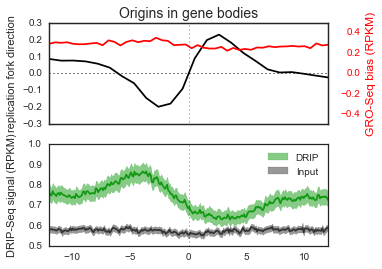

In [37]:
mpl.rc('font', family='Arial')
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,4))

plot_mean_with_95ci(drip_boot['ho_cd_input'] * 10, '#333333', ax[1])
plot_mean_with_95ci(drip_boot['ho_cd'] * 10, '#119911', ax[1])
ax[0].set_title('Origins in gene bodies', fontsize=14)
ax[1].set_ylabel('DRIP-Seq signal (RPKM)', labelpad=11.0)
figure_handles = [mpl.patches.Patch(color='#119911', alpha=0.5),
                  mpl.patches.Patch(color='#333333', alpha=0.5)]
ax[1].legend(labels=['DRIP', 'Input'], handles = figure_handles, loc='upper right')
ax[1].set_ylim(0.5,1.0)
#ax[1].xaxis.set_visible(False)
ax[1].yaxis.tick_left()

ax[0].plot(np.linspace(-12,12,24), rfd['ho_cd'][single_genes_body, 0:24].mean(axis=0), 'k')
ax_right_1 = ax[0].twinx()
ax_right_1.plot(np.linspace(-12,12,48), gro_seq['ho_cd'][single_genes_body, 0:48].mean(axis=0) * 2,
           color = '#ff0000'
          )
ax[0].set_ylim(-0.30,0.30)
ax[0].set_ylabel("replication fork direction")
ax[0].xaxis.tick_bottom()
ax_right_1.set_ylim(-0.5,0.5)
ax_right_1.set_ylabel("GRO-Seq bias (RPKM)", color='r', fontsize=12)

ax_right_1.tick_params('y', colors='r')
for i, label in enumerate(ax_right_1.get_yticklabels()):
    transform = mpl.transforms.ScaledTranslation(14.7,-0.6 + ( 0.2 * i),ax_right_1.transData)
    label.set_horizontalalignment('right')
    label.set_transform(transform)
    
ax[0].plot([-12,12],[0,0], linestyle='dotted', color='k', linewidth=1)

for i in range(2):
    ax[i].plot([0,0],[-1,1], linestyle='dotted', color='k', linewidth=0.5)

ax[1].set_xlim(-12,12)
ax[0].set_xlim(-12,12)

(-12, 12)

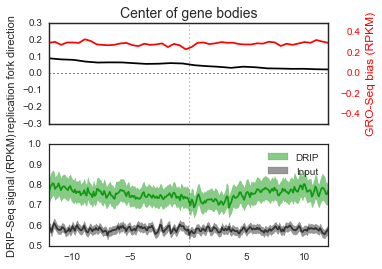

In [38]:
mpl.rc('font', family='Arial')
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,4))

plot_mean_with_95ci(drip_boot['gene_centers_input'] * 10, '#333333', ax[1])
plot_mean_with_95ci(drip_boot['gene_centers'] * 10, '#119911', ax[1])
ax[0].set_title('Center of gene bodies', fontsize=14)
ax[1].set_ylabel('DRIP-Seq signal (RPKM)', labelpad=11.0)
figure_handles = [mpl.patches.Patch(color='#119911', alpha=0.5), mpl.patches.Patch(color='#333333', alpha=0.5)]
ax[1].legend(labels=['DRIP', 'Input'], handles = figure_handles, loc='upper right')
ax[1].set_ylim(0.5,1.0)
#ax[1].xaxis.set_visible(False)
ax[1].yaxis.tick_left()

ax[0].plot(np.linspace(-12,12,24), rfd['centers'].mean(axis=0), 'k')
ax_right_1 = ax[0].twinx()
ax_right_1.plot(np.linspace(-12,12,48), gro_seq['centers'][:, 0:48].mean(axis=0) * 2,
           color = '#ff0000'
          )
ax[0].set_ylim(-0.30,0.30)
ax[0].set_ylabel("replication fork direction")
ax[0].xaxis.tick_bottom()
ax_right_1.set_ylim(-0.5,0.5)
ax_right_1.set_ylabel("GRO-Seq bias (RPKM)", color='r', fontsize=12)

ax_right_1.tick_params('y', colors='r')
for i, label in enumerate(ax_right_1.get_yticklabels()):
    transform = mpl.transforms.ScaledTranslation(14.7,-0.6 + ( 0.2 * i),ax_right_1.transData)
    label.set_horizontalalignment('right')
    label.set_transform(transform)
    
ax[0].plot([-12,12],[0,0], linestyle='dotted', color='k', linewidth=1)

for i in range(2):
    ax[i].plot([0,0],[-1,1], linestyle='dotted', color='k', linewidth=0.5)

ax[1].set_xlim(-12,12)
ax[0].set_xlim(-12,12)